In [1]:
from urban_growth.simulator import *
from urban_growth.estimator import *
from scipy.optimize import approx_fprime
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Generate Some Data

In [37]:
# Initial Configuration
L = 100
rho = .47
blur = 3

# model type
model = 'logistic'

# rural-to-urban threshold
T_vec = [100]

# dynamical parameters

pars = {'alpha' : np.array([100, 200]),
#         'pi'    : np.array([.3, .7]),
        'gamma' : np.array([2.0, 2.8]),
        'beta' : np.array([-10])
       }

Step 1 completed


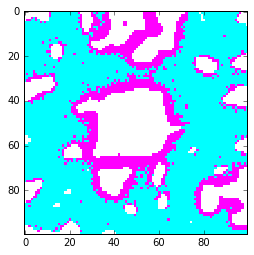

In [38]:
M0 = random_mat(L, rho, blur = blur)
m = simulator(M0 = M0, model = model)

M1 = m.dynamics(T_vec = T_vec,
                n_iters = 1, 
                verbose = True,  
                **pars)

X = M1 - m.M0
X[m.M0 == 1] = np.nan
plt.imshow(X, interpolation = 'nearest', cmap = 'cool')

# First Steps Toward Inference

## Initialize Estimator 

In [39]:
e = estimator(M0 = M0, model = model)
e.update_morphology()
e.partition_clusters(T_vec)
e.make_dist_array(trunc = 50)

In [40]:
e.logistic_log_likelihood(X, normalized = True, use_grad = False, **pars)

urban_growth/estimator.py:20: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))
urban_growth/estimator.py:20: RuntimeWarning: invalid value encountered in multiply
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))


-0.14218032584494961

In [41]:
pars_0 = {'alpha' : np.array([50, 80]),
          'gamma' : np.array([3.5, 2.8]), 
          'beta'  : np.array([-2])
       }

pars_hat, ll_hat, h_inv = e.logistic_ML(X, pars_0, use_grad = True, opts = {'disp' : True})

Optimization terminated successfully.
         Current function value: 0.141803
         Iterations: 81
         Function evaluations: 88
         Gradient evaluations: 88


urban_growth/estimator.py:22: RuntimeWarning: invalid value encountered in divide
  coef = X / d - (1 - X) / (1 - d)


In [42]:
np.set_printoptions(precision=4)
pars_hat

array([  93.454 ,  197.4446,    2.0879,    2.8303,   -9.3882])

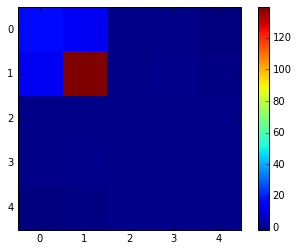

In [43]:
plt.imshow(h_inv / np.nansum(np.isfinite(X)), interpolation='nearest')
plt.colorbar()

In [44]:
np.set_printoptions(precision=2)
np.around(h_inv / np.nansum(np.isfinite(X)), 2)

array([[  1.78e+01,   1.30e+01,  -1.60e-01,  -3.00e-02,  -1.48e+00],
       [  1.30e+01,   1.40e+02,  -1.20e-01,   4.10e-01,  -7.50e-01],
       [ -1.60e-01,  -1.20e-01,   0.00e+00,   0.00e+00,   1.00e-02],
       [ -3.00e-02,   4.10e-01,   0.00e+00,   0.00e+00,   0.00e+00],
       [ -1.48e+00,  -7.50e-01,   1.00e-02,   0.00e+00,   1.30e-01]])

In [45]:
c, d_pars = linear_components(m, pars['alpha'], pars['gamma'], use_grad = True)

# Gradients

In [ ]:
def f(v):
    arr = from_vec(v, model)
    pars = from_array(arr, model)
    return e.log_likelihood(X, normalized = True, **pars)

v = to_vec(to_array(pars, model))
true_grad = from_vec(approx_fprime(v, f, .00000000001), model)
true_grad

In [ ]:
pars = from_array(from_vec(v, model), model)

ll, computed_grad = e.log_likelihood(X, 
                                     normalized = True, 
                                     use_grad = True, 
                                     **pars)
computed_grad

In [ ]:
a, b = 10, 10
def g(v):
    arr = from_vec(v, model)
    pars = from_array(arr, model)
    return linear_components(e, 
                             pars['alpha'], 
                             pars['gamma'])[0, a, b]

true_grad = from_vec(approx_fprime(v, g, .00000001), model)
true_grad

In [ ]:
c, computed_grad = linear_components(e, 
                             pars['alpha'], 
                             pars['gamma'], use_grad = True)

In [ ]:
computed_grad[1, 0, a, b]

# Maximum Likelihood Estimation (Brute Force)

In [ ]:
%%timeit

pars_0 = {'alpha' : np.array([2, 9]),
          'pi'    : np.array([.7, .3]),
          'gamma' : np.array([2.5, 2.8])
       }

pars_hat, ll, h_inv = e.ML(X, 
                           pars_0, 
                           use_grad = True, 
                           opts = {'disp' : True}) 